# Develop Functionality to Approximate :math:`Y^{(k)}(τ)`

First, I extend the functionality to calculate the state at the end as well as the derivative. Then...

In this code I tested Automatic Differentian of the P matrix and demonstrate that it gives the same result that is obtained using modified functionality from MATLAB code. In order to do this, I modifed ForwardDiff.jl and created a pull request 
https://github.com/JuliaDiff/ForwardDiff.jl/pull/182#issuecomment-269486883

so that Parameters could be passed to the functions, but it turns out that passing arguments using closures is better. So, I removed my functionality for passing additional args to functions. Also, more on topic I benchmared Automatic Differetiaion and is seems to perform much worse than the functionality that I modifed for julia. Albiet, the same result was obtained so at the least it was simply an additional test. 

In [1]:
using NLOptControl
using Polynomials
using Plots
using FastGaussQuadrature
using LaTeXStrings
using ForwardDiff
pyplot()
#default(guidefont = font(17), tickfont = font(15), legendfont = font(12), titlefont = font(20))

INFO: Recompiling stale cache file /home/febbo/.julia/lib/v0.5/MacroTools.ji for module MacroTools.
INFO: Recompiling stale cache file /home/febbo/.julia/lib/v0.5/Media.ji for module Media.
INFO: Recompiling stale cache file /home/febbo/.julia/lib/v0.5/DataStructures.ji for module DataStructures.
INFO: Recompiling stale cache file /home/febbo/.julia/lib/v0.5/DiffEqBase.ji for module DiffEqBase.
INFO: Recompiling stale cache file /home/febbo/.julia/lib/v0.5/Juno.ji for module Juno.
INFO: Recompiling stale cache file /home/febbo/.julia/lib/v0.5/StochasticDiffEq.ji for module StochasticDiffEq.
INFO: Recompiling stale cache file /home/febbo/.julia/lib/v0.5/GenericSVD.ji for module GenericSVD.
INFO: Recompiling stale cache file /home/febbo/.julia/lib/v0.5/FiniteElementDiffEq.ji for module FiniteElementDiffEq.
INFO: Recompiling stale cache file /home/febbo/.julia/lib/v0.5/DiffEqDevTools.ji for module DiffEqDevTools.
INFO: Recompiling stale cache file /home/febbo/.julia/lib/v0.5/OrdinaryDiffE

Plots.PyPlotBackend()


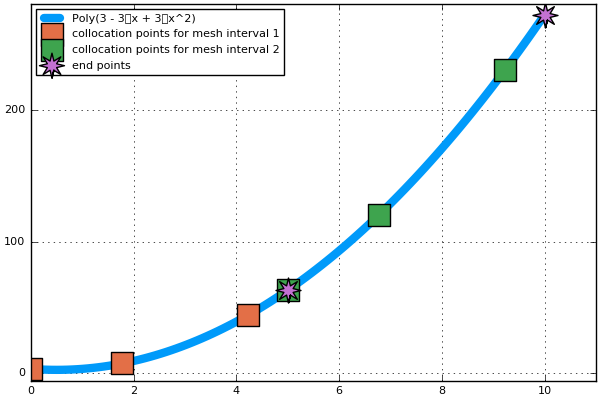

In [2]:
# define problem
t0 = Float64(0); tf = Float64(10);  # TODO change and y to x
t = Array(linspace(t0,tf,100));
α₁ =  3; α₂ = -3; α₃ = -8; α₄ =  7;
Nc = Int64(3); # number of collocation points in each interval
Ni = Int64(2);  # number of intervals
####################################
# perform analytical calcualtions
####################################
γ = Poly([α₁,α₂,α₁]); #TODO check on that imported binding warning
y = polyval(γ,t);

# evaluate the integral
∫γ = polyint(γ);
Y = polyval(∫γ,t[end]) - polyval(∫γ,t[1]);
C = Y - polyval(∫γ,t[end]); # constant of integration
∫y = polyval(∫γ,t) + C;

# evaluate the derivative
dγ = polyder(γ);
dy = polyval(dγ,t);

####################################
# construct polynomial approximation
####################################
τ, ω = gaussradau(Nc); # number of collocation points per interval

# break the problem up into multiple intervals
di, tm, t_data, ωₛ = create_intervals(t0,tf,Ni,Nc,τ,ω); # TODO probably get ride of some of the output

temp = zeros(Float64,1,Ni)
for idx in 1:Ni
  temp[idx] = di*idx;
end
t_dataE = [t_data;temp];
# approximate state (or polynomial)
state_data = zeros(Float64,Nc+1,Ni); 
for idx in 1:Ni
  state_data[:,idx] = polyval(γ,t_dataE[:,idx]);
end
P = zeros(Float64,Nc+1,Ni);
for idx in 1:Ni
  P[:,idx] = interpolate_lagrange(t_dataE[:,idx],t_dataE[:,idx],state_data[:,idx],Nc)
end 
#################
# post processing
#################
tF = zeros(Float64,Ni); yF =  zeros(Float64,Ni);
plot(0,leg=:false);
plot!(t,y,label=string(γ),w=6)
for idx in 1:Ni
  scatter!(t_dataE[1:end-1,idx],P[1:end-1,idx],markersize =16,markershape = :rect,label=string("collocation points for mesh interval ",idx))
  tF[idx] = t_dataE[end,idx];
  yF[idx] = P[end,idx];
end
scatter!(tF,yF,markersize = 18,markershape = :star8,label=string("end points"))
xlims!(t0,tf*1.1)


## Approximate Derivatives and Integral


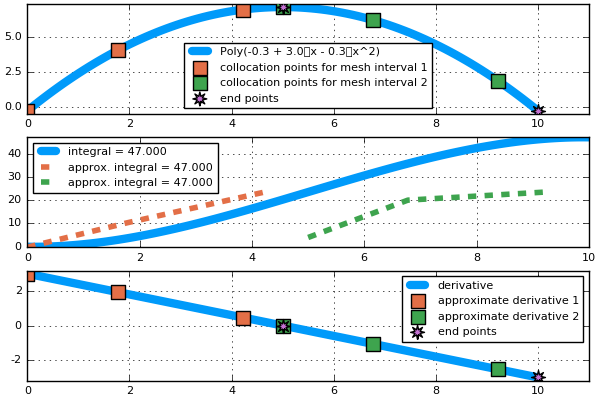

In [7]:
"""
# variables
* int = index for interval
* inx = index for collocation point
"""
# define problem
t0 = Float64(0); tf = Float64(10);  # TODO change and y to x
t = Array(linspace(t0,tf,100));
α₁ =  -0.3; α₂ = 3; α₃ = -8; α₄ =  7;
Nc = Int64(3); # number of collocation points in each interval
Ni = Int64(2);  # number of intervals
####################################
# perform analytical calcualtions
####################################
γ = Poly([α₁,α₂,α₁]); #TODO check on that imported binding warning
y = polyval(γ,t);

# evaluate the integral
∫γ = polyint(γ);
Y = polyval(∫γ,t[end]) - polyval(∫γ,t[1]);
C = Y - polyval(∫γ,t[end]); # constant of integration
∫y = polyval(∫γ,t) + C;

# evaluate the derivative
dγ = polyder(γ);
dy = polyval(dγ,t);

####################################
# construct polynomial approximation
####################################
τ, ω = gaussradau(Nc); # number of collocation points per interval

# break the problem up into multiple intervals
di, tm, t_data, ωₛ = create_intervals(t0,tf,Ni,Nc,τ,ω); # TODO probably get ride of some of the output

temp = zeros(Float64,1,Ni)
for int in 1:Ni
  temp[int] = di*int;
end
t_dataE = [t_data;temp];
# approximate state (or polynomial)
state_data = zeros(Float64,Nc+1,Ni);
for int in 1:Ni
  state_data[:,int] = polyval(γ,t_dataE[:,int]);
end
P = zeros(Float64,Nc+1,Ni);
for int in 1:Ni
  P[:,int] = interpolate_lagrange(t_dataE[:,int],t_dataE[:,int],state_data[:,int],Nc)
end

# approximate the integral
ζ = zeros(Float64,Nc,Ni); fτ = zeros(Float64,Nc,Ni);approx_int = Float64(0);
for idx in 1:Ni
  fτ[:,idx] = polyval(γ,t_data[:,idx]);
  ζ[:,idx] =  cumsum(ωₛ[:,idx].*fτ[:,idx],1)
  approx_int = approx_int + ζ[end,idx];
end
# approximate the derivative --> needed in defect constraints
dζ = zeros(Float64,Nc+1,Ni);fτE = zeros(Float64,Nc+1,Ni); D = zeros(Float64,Nc+1,Nc+1,Ni);
for int in 1:Ni
  fτE[:,int] = polyval(γ,t_dataE[:,int]);
  D[:,:,int] = poldif(t_dataE[:,int], 1)
  dζ[:,int] = D[:,:,int]*fτE[:,int]
end

#################
# post processing
#################
tF = zeros(Float64,Ni); yF =  zeros(Float64,Ni);
fp=plot(0,leg=:false);
plot!(t,y,label=string(γ),w=6)
for int in 1:Ni
  scatter!(t_dataE[1:end-1,int],P[1:end-1,int],markersize =10,markershape = :rect,label=string("collocation points for mesh interval ",int))
  tF[int] = t_dataE[end,int];
  yF[int] = P[end,int];
end
scatter!(tF,yF,markersize = 10,markershape = :star8,label=string("end points"))
xlims!(t0,tf*1.1)

dp=plot(0,leg=:false)
plot!(t,dy,label="derivative",w=6)
for int in 1:Ni
  scatter!(t_dataE[1:end-1,int],dζ[1:end-1,int],markersize =10,markershape = :rect,label=string("approximate derivative ",int))
  tF[int] = t_dataE[end,int];
  yF[int] = dζ[end,int];
end
scatter!(tF,yF,markersize = 10,markershape = :star8,label=string("end points"))
xlims!(t0,tf*1.1)

ip=plot(0,leg=:false)
plot!(t,∫y,label=@sprintf("integral = %0.3f",∫y[end]),w=6)
plot!(t_data,ζ,label=@sprintf("approx. integral = %0.3f",approx_int),line=(4,:dash))

plot(fp,ip,dp,layout=(3,1))


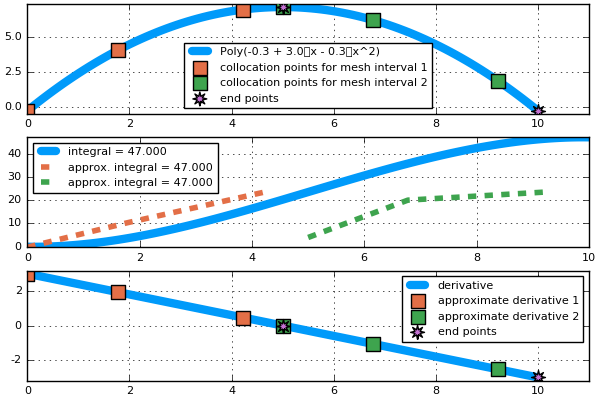

In [6]:
D

4×4×2 Array{Float64,3}:
[:, :, 1] =
 -1.0         1.50639   -1.10639    0.6     
 -0.210639   -0.155051   0.713568  -0.347878
  0.0506395  -0.233568  -0.644949   0.827878
 -0.0666667   0.276429  -2.00976    1.8     

[:, :, 2] =
 -1.0         1.50639   -1.10639    0.6     
 -0.210639   -0.155051   0.713568  -0.347878
  0.0506395  -0.233568  -0.644949   0.827878
 -0.0666667   0.276429  -2.00976    1.8     

# Calculate D using new functionality created for ForwardDiff.jl

In [18]:
tic()
D = zeros(Float64,Nc,Nc+1,Ni)
for int in 1:Ni
    for idx in 1:Nc
        for j in 1:Nc+1
            D[idx,j,int] = ForwardDiff.derivative(lagrange_basis_poly, t_data[idx,int], t_dataE[:,int], Nc, j)
        end
    end
end
toc()

elapsed time: 0.019735022 seconds


0.019735022

# Same Values!! But it Takes Way Longer:/

In [19]:
D

3×4×2 Array{Float64,3}:
[:, :, 1] =
 -1.0         1.50639   -1.10639    0.6     
 -0.210639   -0.155051   0.713568  -0.347878
  0.0506395  -0.233568  -0.644949   0.827878

[:, :, 2] =
 -1.0         1.50639   -1.10639    0.6     
 -0.210639   -0.155051   0.713568  -0.347878
  0.0506395  -0.233568  -0.644949   0.827878

In [21]:
for int in 1:Ni
  fτE[:,int] = polyval(γ,t_dataE[:,int]);
 # D[:,:,int] = poldif(t_dataE[:,int], 1);
  dζ[:,int] = fτE[:,int]*D[:,:,int];
end

LoadError: DimensionMismatch("tried to assign 3-element array to 4×1 destination")

In [27]:
D[:,:,1]'

4×3 Array{Float64,2}:
 -1.0      -0.210639   0.0506395
  1.50639  -0.155051  -0.233568 
 -1.10639   0.713568  -0.644949 
  0.6      -0.347878   0.827878 

In [28]:
D[:,:,1]

3×4 Array{Float64,2}:
 -1.0         1.50639   -1.10639    0.6     
 -0.210639   -0.155051   0.713568  -0.347878
  0.0506395  -0.233568  -0.644949   0.827878

In [30]:
fτE[:,1]'*D[:,:,1]'

1×3 Array{Float64,2}:
 3.0  1.93485  0.465153

In [31]:
fτE[:,1]

4-element Array{Float64,1}:
 -0.3    
  4.08031
  7.01969
  7.2    


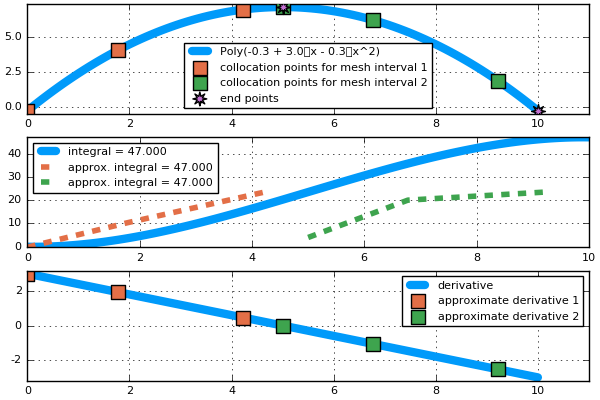

In [39]:
dζ = zeros(Float64,Nc,Ni);
for int in 1:Ni
  fτE[:,int] = polyval(γ,t_dataE[:,int]);
 # D[:,:,int] = poldif(t_dataE[:,int], 1);
  dζ[:,int] = fτE[:,int]'*D[:,:,int]';
end

#################
# post processing
#################
tF = zeros(Float64,Ni); yF =  zeros(Float64,Ni);
fp=plot(0,leg=:false);
plot!(t,y,label=string(γ),w=6)
for int in 1:Ni
  scatter!(t_dataE[1:end-1,int],P[1:end-1,int],markersize =10,markershape = :rect,label=string("collocation points for mesh interval ",int))
  tF[int] = t_dataE[end,int];
  yF[int] = P[end,int];
end
scatter!(tF,yF,markersize = 10,markershape = :star8,label=string("end points"))
xlims!(t0,tf*1.1)

dp=plot(0,leg=:false)
plot!(t,dy,label="derivative",w=6)
for int in 1:Ni
  scatter!(t_data[:,int],dζ[:,int],markersize =10,markershape = :rect,label=string("approximate derivative ",int))
  #tF[int] = t_dataE[end,int];
 # yF[int] = dζ[end,int];
end
#scatter!(tF,yF,markersize = 10,markershape = :star8,label=string("end points"))
xlims!(t0,tf*1.1)

ip=plot(0,leg=:false)
plot!(t,∫y,label=@sprintf("integral = %0.3f",∫y[end]),w=6)
plot!(t_data,ζ,label=@sprintf("approx. integral = %0.3f",approx_int),line=(4,:dash))

plot(fp,ip,dp,layout=(3,1))



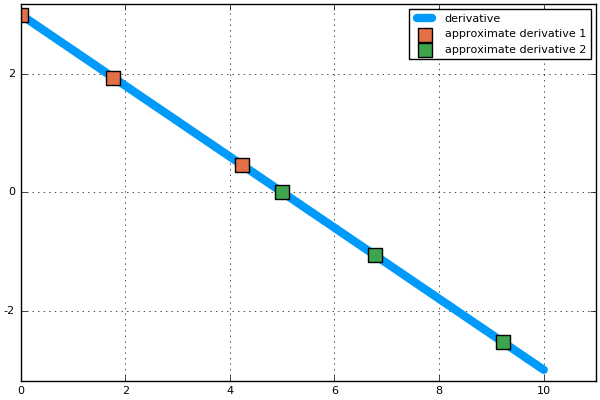

In [37]:
dp=plot(0,leg=:false)
plot!(t,dy,label="derivative",w=6)
for int in 1:Ni
  scatter!(t_data[:,int],dζ[:,int],markersize =10,markershape = :rect,label=string("approximate derivative ",int))
  #tF[int] = t_data[end,int];
  #yF[int] = dζ[end,int];
end
#scatter!(tF,yF,markersize = 10,markershape = :star8,label=string("end points"))
xlims!(t0,tf*1.1)


Notice that the end point is not repeated in the middle. Avoid having to constrain the fucntion here! Otherwise, we would have to constrain the function. What about the very last point? What do we do with that?

# Using The Jacobian

In [17]:
D = zeros(Float64,Nc,Nc+1,Ni)
tic()
for int in 1:Ni
    for idx in 1:Nc
        for j in 1:Nc+1
            D[idx,j,int] = ForwardDiff.derivative(lagrange_basis_poly, t_data[idx,int], t_dataE[:,int], Nc, j)
        end
    end
end
toc()




In [72]:

ForwardDiff.jacobian(x -> lagrange_basis_poly(x, [1, 2, 3], 2), [1.0, 2.0])
#toc()

LoadError: MethodError: Cannot `convert` an object of type ForwardDiff.Dual{2,Float64} to an object of type Float64
This may have arisen from a call to the constructor Float64(...),
since type constructors fall back to convert methods.

In [74]:
D

9×2 Array{Float64,2}:
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0

In [43]:
int=1
t_data[:,int]

3-element Array{Float64,1}:
 0.0    
 1.77526
 4.22474

In [44]:
t_dataE[:,int]

4-element Array{Float64,1}:
 0.0    
 1.77526
 4.22474
 5.0    

In [60]:
t_data[:,int]

3-element Array{Float64,1}:
 5.0    
 6.77526
 9.22474